<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-imports-and-dfs" data-toc-modified-id="Load-imports-and-dfs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load imports and dfs</a></span></li><li><span><a href="#Using-LGBM" data-toc-modified-id="Using-LGBM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Using LGBM</a></span></li><li><span><a href="#Using-XGboost-(not-helping)" data-toc-modified-id="Using-XGboost-(not-helping)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using XGboost (not helping)</a></span></li><li><span><a href="#Stacking" data-toc-modified-id="Stacking-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stacking</a></span></li><li><span><a href="#Use-LGBM-without-kfold-on-outliers-for-blending" data-toc-modified-id="Use-LGBM-without-kfold-on-outliers-for-blending-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Use LGBM without kfold on outliers for blending</a></span></li><li><span><a href="#Stacking-using-Bayesian-Ridge" data-toc-modified-id="Stacking-using-Bayesian-Ridge-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Stacking using Bayesian Ridge</a></span></li><li><span><a href="#File-link" data-toc-modified-id="File-link-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>File link</a></span></li></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 4
%autosave 120

Autosaving every 120 seconds


1. Load imports & test, train DFs
2. Apply stratified kfold & traing with lgbm and submit to kaggle
3. Check for missing data feature engineering parts missed if score > 3.7
4. Split the training set to train & validation
5. Train over RF to get a benchmark of the dataset
6. Drop irrelevant features by sorting on feature importance
7. Drop redundant features by plotting a Dendogram and removing the redundancy
8. Use a feature interpreter to see which feature is contributing lot to prediction
9. Use extrapolation to see if we can remove feature which add bias of training & validation set
10. Use partial dependence plot to see outliers/missed features
11. Submit to kaggle the RF model and see the score
11. Use stratified kfold to train the RF model and submit to kaggle
12. Repeat again with LGBM/XGBoost/Adaboost. Stack the model and submit to kaggle


### Load imports and dfs

In [2]:
from fastai.io import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn import metrics
import feather
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, RepeatedKFold
from sklearn.metrics import mean_squared_error
import warnings

In [3]:
train_df2 = feather.read_dataframe('train_df')
test_df2 = feather.read_dataframe('test_df')

In [4]:
for df in [train_df2, test_df2]:
    for f in ['purchase_date_max','purchase_date_min','purchase_date_max_old',\
                     'purchase_date_min_old']:
        df[f] = df[f].astype(np.int64) * 1e-9

In [5]:
del_cols = ['first_active_monthIs_month_start', 'authorized_flag_1_mean', 'first_active_monthIs_year_start',
       'first_active_monthIs_year_end', 'first_active_monthIs_quarter_end', 'avg_trans_per_merchant',
       'first_active_monthIs_month_end', 'first_active_monthDay', 'card_id_size',
       'authorized_flag_1_amount_mean_mean', 'authorized_flag_1_amount_sum_sum','card_id', 'first_active_month','target','outliers']

In [6]:
def one_hot_encode_fe(df):
    return pd.get_dummies(df, columns=['feature_1', 'feature_2', 'feature_3'])

In [7]:
# [train_df2, test_df2] = [one_hot_encode_fe(d) for d in [train_df2, test_df2]]

In [8]:
df_train_columns = [c for c in train_df2.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train_df2['target']

In [9]:
train_df2.shape, test_df2.shape

((201917, 135), (123623, 133))

In [10]:
target.shape

(201917,)

In [11]:
del train_df2['target']

In [12]:
len(df_train_columns)

131

In [13]:
from scipy.stats import ks_2samp
list_p_value =[]

for i in tqdm(df_train_columns):
    list_p_value.append(ks_2samp(test_df2[i] , train_df2[i])[1])

Se = pd.Series(list_p_value, index = df_train_columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

100%|██████████| 131/131 [00:03<00:00, 41.54it/s]


In [14]:
list_discarded

['avg_spend_per_transaction',
 'purchase_amount_mean',
 'avg_spend_per_merchant',
 'purchase_amount_max_old',
 'purchase_amount_total_mean',
 'category_3_mean_mean_old',
 'purchase_amount_sum']

In [106]:
# df_train_columns = [c for c in df_train_columns if c not in list_discarded]

In [15]:
len(df_train_columns)

131

### Using LGBM

In [16]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train_df2))
predictions = np.zeros(len(test_df2))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df2,train_df2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df2.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_df2.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train_df2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df2[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66487	valid_1's rmse: 3.72105
[200]	training's rmse: 3.58667	valid_1's rmse: 3.68688
[300]	training's rmse: 3.53977	valid_1's rmse: 3.67242
[400]	training's rmse: 3.5035	valid_1's rmse: 3.66458
[500]	training's rmse: 3.47327	valid_1's rmse: 3.65957
[600]	training's rmse: 3.44785	valid_1's rmse: 3.65695
[700]	training's rmse: 3.42615	valid_1's rmse: 3.65539
[800]	training's rmse: 3.40644	valid_1's rmse: 3.65447
[900]	training's rmse: 3.38785	valid_1's rmse: 3.65337
[1000]	training's rmse: 3.37083	valid_1's rmse: 3.65292
Early stopping, best iteration is:
[971]	training's rmse: 3.3757	valid_1's rmse: 3.65287
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.6669	valid_1's rmse: 3.71284
[200]	training's rmse: 3.58858	valid_1's rmse: 3.68074
[300]	training's rmse: 3.53967	valid_1's rmse: 3.67003
[400]	training's rmse: 3.50217	valid_1's rmse: 3.66373
[5

3.6549983949875506

In [17]:
np.save('oof_lgb_3', oof)
np.save('predictions_lgb_3', predictions)

1. Score for submission-2019-01-11 10:18:09.909061.csv - 3.6597596743401666, LB - 3.707 (included cat_1)
2. Score for submission-2019-01-12 13:53:27.215115.csv - 3.656726211308068, LB - 3.696 (jst refactored)
3. No changes what so ever - 3.6627995460091523
4. Replaced with kernels code - 3.6623128394907103
5. Replaced with kernels code along with cat_2 mean - 3.6609564684554594
6. Added extra feature - 3.6559302073797637, LB - 3.696 (No grouping by auth flag and all)
7. Added aggs on cat_1, auth - 3.6554801486969906, LB- 3.696
8. Removed unnecessary cols - 3.6556548946965446, LB - 3.696
9. Removed aggs on cat_1 - 3.654208034404632, LB - 3.697
10. Removed unnecessary del_cols - 3.65493381575084, LB - 3.697
11. One hot encoded features - 3.6558286566186897
12. Added monthly aggregates - 3.653533666238162, LB - 3.716
13. Removed some monthly aggregates - 3.654769374794982, LB - 3.707
14. reverting to earlier checkpoing - 3.65377489489624
15. Benchmarks - LGBM - 3.654910478618945, DL - 3.6971527526968155
16. Just ran the whole FE page -submission-2019-01-20 01:46:39.187580.csv - 3.6546249070742816 - 3.696
17. Changed hyperparams of LGBM - 3.654728019446817
18. With changed hyperparams - 7 fold - 3.6532023662229682 - 3.696
19. Changed random seed to 2019 - 3.6591621358131183
20. Added extra features with old hyper params - 3.6549729015873496, submission-2019-01-20 19:11:58.593189.csv -3.696
21. Added days*features column - 3.6549983949875506

**Stacking:**
1. LGBM-3.6550013784231608, XGBoost-3.6594364661840606, stacked-3.6517291440175144. LB - 3.697
2. 3.6550013784231608, 3.656226013110323, 3.652125180502318. LB -  3.698

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


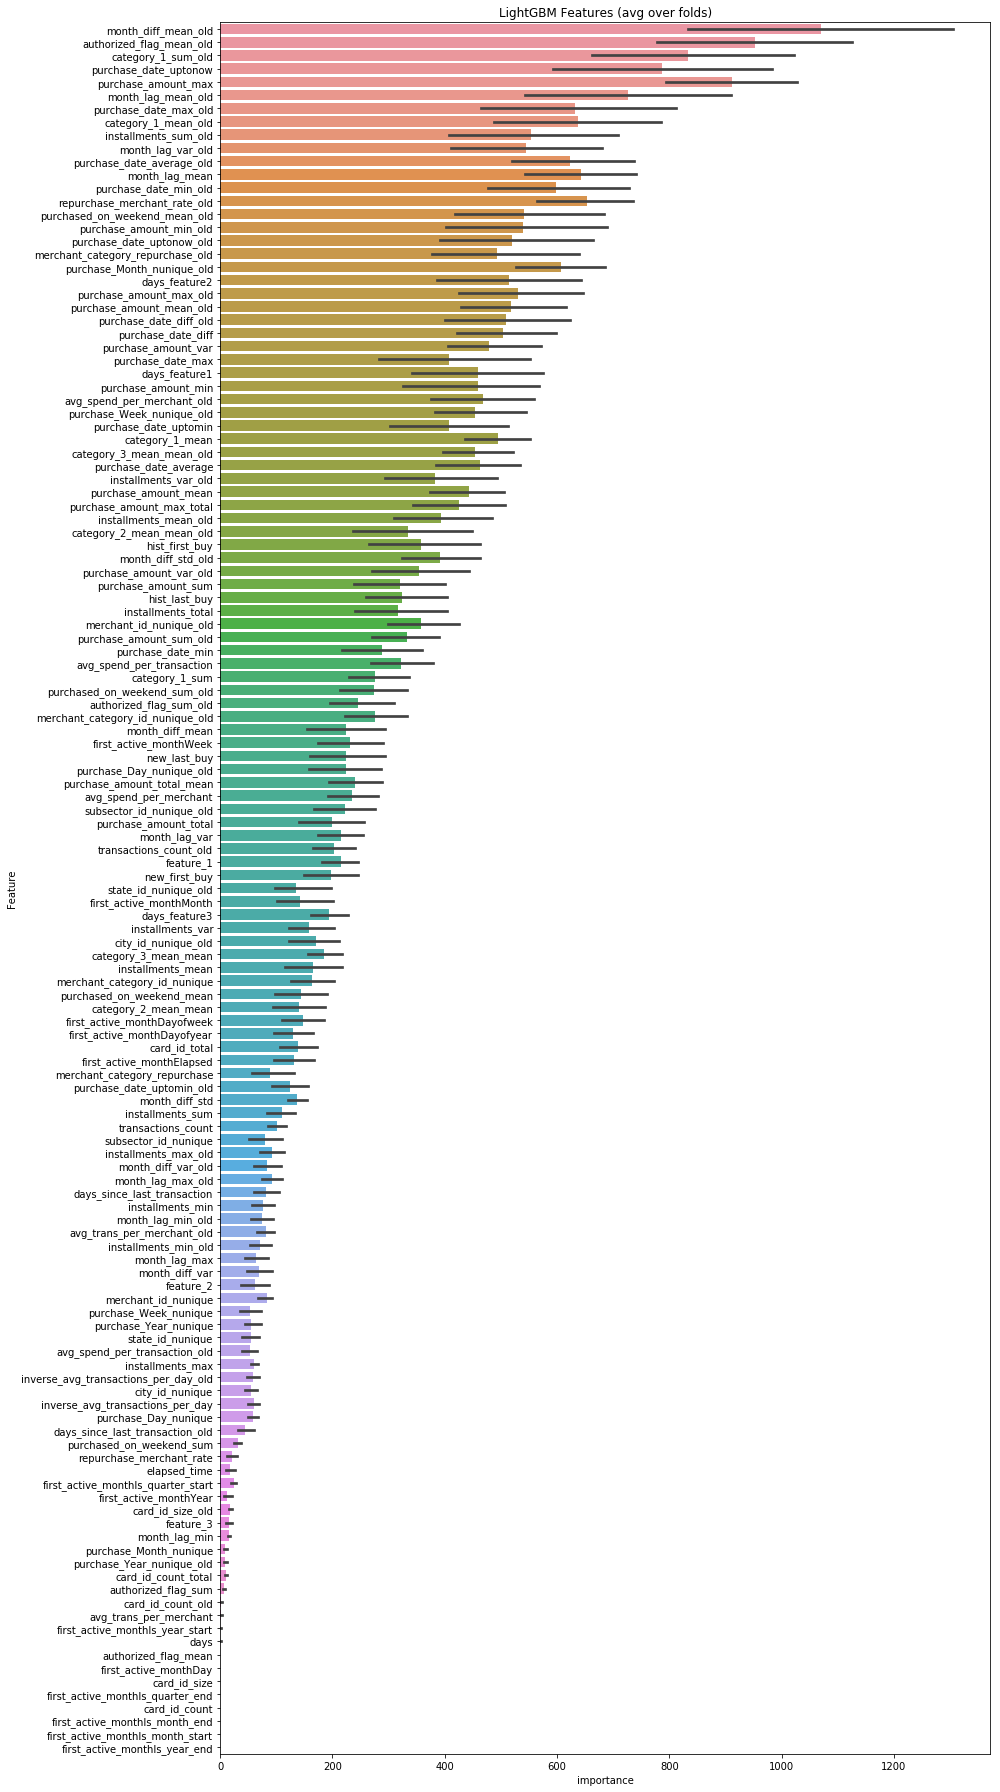

In [18]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [19]:
best_features.sort_values(by='importance', ascending=True)[:50]['Feature'].unique()

array(['authorized_flag_mean', 'first_active_monthIs_year_end', 'first_active_monthIs_month_start',
       'first_active_monthIs_year_start', 'first_active_monthIs_quarter_end', 'card_id_size',
       'first_active_monthDay', 'first_active_monthIs_month_end', 'avg_trans_per_merchant',
       'authorized_flag_sum', 'repurchase_merchant_rate', 'purchase_Year_nunique_old'], dtype=object)

### Using XGboost (not helping)

In [16]:
import xgboost as xgb

In [46]:
xgb_params = {'eta': 0.01, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'scale_pos_weight': 1, 
              'min_child_weight': 1 }

oof_xgb_3 = np.zeros(len(train_df2))
predictions_xgb_3 = np.zeros(len(test_df2))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df2,train_df2['outliers'].values)):    
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=train_df2.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train_df2.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb_3[val_idx] = xgb_model.predict(xgb.DMatrix(train_df2.iloc[val_idx][df_train_columns]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb_3 += xgb_model.predict(xgb.DMatrix(test_df2[df_train_columns]), ntree_limit=xgb_model.best_ntree_limit+50) / folds.n_splits
    
np.save('oof_xgb_3', oof_xgb_3)
np.save('predictions_xgb_3', predictions_xgb_3)
np.sqrt(mean_squared_error(target.values, oof_xgb_3))

-
Fold 1
xgb 0--------------------------------------------------
[17:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=8
[0]	train-rmse:3.94515	valid-rmse:3.95135
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[17:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=8
[17:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=8
[17:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=8
[17:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=8
[17:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=8
[17:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 43

[17:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=8
[17:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=8
[17:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=8
[17:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=8
[17:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=8
[17:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=8
[17:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=8
[17:08:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=8
[17:08:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned no

[17:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=8
[17:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=8
[17:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=8
[17:08:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=8
[17:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=8
[17:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[17:08:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=8
[17:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=8
[17:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned no

[17:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[17:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=8
[17:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=8
[17:08:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=8
[17:08:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=8
[17:08:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=8
[17:08:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=8
[17:08:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=8
[17:08:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned no

[17:09:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=8
[17:09:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=8
[17:09:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[17:09:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[17:09:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=8
[17:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=8
[17:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=8
[17:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=8
[17:09:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned no

[17:09:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[17:09:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[17:09:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[17:09:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=8
[17:09:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=8
[17:09:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=8
[17:09:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=8
[17:09:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=8
[17:09:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned no

[17:10:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[17:10:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=8
[17:10:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=8
[17:10:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=8
[17:10:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=8
[17:10:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=8
[17:10:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[17:10:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=8
[17:10:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned no

[17:10:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[17:10:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[17:10:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=8
[17:10:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8
[17:10:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[17:10:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[17:10:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[17:10:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=8
[17:10:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned no

[17:10:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[17:10:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=8
[17:10:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[17:10:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[17:10:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[17:10:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[17:10:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[17:10:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[17:10:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned no

[17:11:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=8
[17:11:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=8
[17:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=8
[17:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=8
[17:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=8
[17:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=8
[17:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=8
[17:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=8
[17:11:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned no

[17:11:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=8
[17:11:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=8
[17:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=8
[17:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=8
[17:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=8
[17:11:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=8
[17:11:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=8
[17:11:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=8
[17:11:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned no

[17:12:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=8
[17:12:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=8
[17:12:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=8
[17:12:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=8
[17:12:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=8
[17:12:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=8
[17:12:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=8
[17:12:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=8
[17:12:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned no

[17:12:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=8
[17:12:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=8
[17:12:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=8
[17:12:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=8
[17:12:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[17:12:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[17:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=8
[17:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=8
[17:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned no

[17:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=8
[17:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=8
[17:12:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[17:12:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=8
[17:12:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[17:12:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=8
[17:12:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[17:12:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=8
[17:12:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned no

[17:13:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=8
[17:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=8
[17:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[17:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[17:13:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[17:13:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=8
[17:13:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[17:13:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[17:13:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned no

[17:13:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=8
[17:13:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[17:13:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=8
[17:13:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[17:13:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=8
[17:13:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=8
[17:13:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[17:13:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[17:13:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned no

[17:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=8
[17:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[17:14:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=8
[17:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=8
[17:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[17:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=8
[17:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=8
[17:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[17:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned no

[17:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=8
[17:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=8
[17:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=8
[17:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=8
[17:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=8
[17:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=8
[17:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=8
[17:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=8
[17:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned no

[17:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=8
[17:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=8
[17:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=8
[17:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=8
[17:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=8
[17:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=8
[17:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=8
[17:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=8
[17:14:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned no

[17:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=8
[17:15:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=8
[17:15:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=8
[17:15:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[17:15:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[17:15:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[17:15:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=8
[17:15:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=8
[17:15:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned no

[17:15:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[17:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=8
[17:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[17:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=8
[17:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[17:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=8
[17:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=8
[17:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=8
[17:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned no

[17:16:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[17:16:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[17:16:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=8
[17:16:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=8
[17:16:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[17:16:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=8
[17:16:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[17:16:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[17:16:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned no

[17:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[17:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[17:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[17:16:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=8
[17:16:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=8
[17:16:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=8
[17:16:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[17:16:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=8
[17:16:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned no

[17:16:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[17:16:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=8
[17:16:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=8
[17:16:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[17:16:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=8
[17:16:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[17:16:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=8
[17:16:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=8
[17:16:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned no

[17:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=8
[17:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[17:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=8
[17:17:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[17:17:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=8
[17:17:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[17:17:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[17:17:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=8
[17:17:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned no

[17:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[17:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[17:17:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=8
[17:17:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[17:17:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=8
[17:17:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=8
[17:17:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[17:17:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[17:17:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned no

[17:18:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=8
[17:18:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=8
[17:18:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=8
[17:18:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=8
[17:18:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=8
[17:18:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=8
[17:18:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=8
[17:18:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=8
[17:18:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned no

[17:18:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=8
[17:18:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=8
[17:18:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=8
[17:18:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=8
[17:18:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=8
[17:18:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=8
[17:18:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=8
[17:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=8
[17:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned no

[17:18:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=8
[17:18:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=8
[17:18:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=8
[17:18:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=8
[17:18:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=8
[17:18:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=8
[17:18:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=8
[17:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=8
[17:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned no

[17:19:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=8
[17:19:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=8
[17:19:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=8
[17:19:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=8
[17:19:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=8
[17:19:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=8
[17:19:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=8
[17:19:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[17:19:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned no

[17:19:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=8
[17:19:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=8
[17:19:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[17:19:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[17:19:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=8
[17:19:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=8
[17:19:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=8
[17:19:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=8
[17:19:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned no

[17:20:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=8
[17:20:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[17:20:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=8
[17:20:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[17:20:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[17:20:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=8
[17:20:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=8
[17:20:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[17:20:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nod

[17:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=8
[17:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[17:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=8
[17:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=8
[17:20:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=8
[17:20:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[17:20:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=8
[17:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=8
[17:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned no

[17:20:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=8
[17:20:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=8
[17:21:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=8
[17:21:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=8
[17:21:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=8
[17:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=8
[17:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=8
[17:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=8
[17:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned no

[17:21:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=8
[17:21:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=8
[17:21:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=8
[17:21:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[17:21:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=8
[17:21:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=8
[17:21:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=8
[17:21:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=8
[17:21:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned no

[17:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=8
[17:21:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=8
[17:21:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[17:21:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=8
[17:21:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 0 pruned nodes, max_depth=8
[17:21:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=8
[17:21:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=8
[17:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=8
[17:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned no

[17:22:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=8
[17:22:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[17:22:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=8
[17:22:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=8
[17:22:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=8
[17:22:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=8
[17:22:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=8
[17:22:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[17:22:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned no

[17:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=8
[17:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[17:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[17:22:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=8
[17:22:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=8
[17:22:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[17:22:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=8
[17:22:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=8
[17:22:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned no

[17:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[17:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=8
[17:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=8
[17:23:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=8
[17:23:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=8
[17:23:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=8
[17:23:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[17:23:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=8
[17:23:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned no

[17:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[17:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=8
[17:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[17:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=8
[17:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=8
[17:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=8
[17:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=8
[17:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=8
[17:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned no

[17:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=8
[17:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=8
[17:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=8
[17:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=8
[17:23:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=8
[17:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=8
[17:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=8
[17:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[17:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned no

[17:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=8
[17:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=8
[17:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=8
[17:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=8
[17:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=8
[17:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[17:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=8
[17:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=8
[17:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned no

3.656226013110323

### Stacking

In [48]:
from sklearn.linear_model import Ridge

In [49]:
train_stack = np.vstack([oof, oof_xgb_3]).transpose()
test_stack = np.vstack([predictions, predictions_xgb_3]).transpose()

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, train_df2['outliers'].values)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    clf = Ridge(alpha=1)
    clf.fit(trn_data, trn_y)
    
    oof[val_idx] = clf.predict(val_data)
    predictions += clf.predict(test_stack) / folds.n_splits


np.sqrt(mean_squared_error(target.values, oof))

fold n°0
fold n°1
fold n°2
fold n°3
fold n°4


3.652125180502318

### Use LGBM without kfold on outliers for blending

In [19]:
cat_features = [c for c in df_train_columns if 'feature_' in c] 

In [20]:
cat_features

['feature_1', 'feature_2', 'feature_3']

In [21]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 27, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4950)
oof_2 = np.zeros(len(train_df2))
predictions_2 = np.zeros(len(test_df2))
feature_importance_df_2 = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df2.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df2.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx], categorical_feature=cat_features)
    val_data = lgb.Dataset(train_df2.iloc[val_idx][df_train_columns], label=target.iloc[val_idx], categorical_feature=cat_features)

    num_round = 10000
    clf_r = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof_2[val_idx] = clf_r.predict(train_df2.iloc[val_idx][df_train_columns], num_iteration=clf_r.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_2 = pd.concat([feature_importance_df_2, fold_importance_df], axis=0)
    
    predictions_2 += clf_r.predict(test_df2[df_train_columns], num_iteration=clf_r.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, target)**0.5))

fold 0


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1054]	training's rmse: 3.26717	valid_1's rmse: 3.66168
fold 1


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[712]	training's rmse: 3.31186	valid_1's rmse: 3.81229
fold 2


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[754]	training's rmse: 3.35715	valid_1's rmse: 3.56932
fold 3


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[881]	training's rmse: 3.30772	valid_1's rmse: 3.62979
fold 4


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[846]	training's rmse: 3.32707	valid_1's rmse: 3.61651
fold 5


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[948]	training's rmse: 3.27317	valid_1's rmse: 3.73203
fold 6


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[646]	training's rmse: 3.36856	valid_1's rmse: 3.63769
fold 7


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[609]	training's rmse: 3.38148	valid_1's rmse: 3.64302
fold 8


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1263]	training's rmse: 3.21901	valid_1's rmse: 3.66376
fold 9


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[597]	training's rmse: 3.39153	valid_1's rmse: 3.60188
CV score: 3.65593 


### Stacking using Bayesian Ridge

In [26]:
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof,oof_2]).transpose()
test_stack = np.vstack([predictions, predictions_2]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=4950)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5
    
np.sqrt(mean_squared_error(target.values, oof_stack))

fold 0
fold 1
fold 2
fold 3
fold 4


3.6526672995445217

1. LGBM Skfold-3.6549729015873496 (3.696 on LB) Rkfold - 3.65591, Stacked - 3.652611210821926, LB-3.696 -submission-2019-01-20 19:35:24.892043.csv
2. LGBM SKFold- 3.6549983949875506, RKfold - 3.65593 , Stacked - 3.6526672995445217, LB - 3.695 : submission-2019-01-20 20:47:32.743729.csv👏 - added days*features 

### File link

In [27]:
sub_df = pd.DataFrame({"card_id":test_df2["card_id"].values})
sub_df["target"] = predictions_3
sub_df.to_csv(f'submission-{pd.to_datetime("today")}.csv', index=False)

In [32]:
sub_df = pd.DataFrame({"card_id":test_df2["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv(f'submission-{pd.to_datetime("today")}.csv', index=False)

In [28]:
!ls

'Elo - ML model - 3.696 beta.ipynb'
'Elo - ML model - 3.696.ipynb'
'Elo - ML model - cat aggregates.ipynb'
'Elo - ML model clean.ipynb'
'Elo - ML model proc_df.ipynb'
'Elo - ML model-RF copy.ipynb'
'Elo - ML model-backup.ipynb'
'Elo - ML model-new.ipynb'
'Elo RF- New.ipynb'
'Elo RF.ipynb'
'Elo end 2 end.ipynb'
'Elo feature engineering - 3.696.ipynb'
'Elo feature engineering 3.696 - beta.ipynb'
'Elo feature engineering using agg.ipynb'
'Elo feature engineering-backup.ipynb'
'Elo feature engineering-proc_df - new-Copy1.ipynb'
'Elo feature engineering-proc_df - new.ipynb'
'Elo feature engineering-proc_df-OLD.ipynb'
'Elo feature engineering-proc_df.ipynb'
'Elo merchant category reco - using RF.ipynb'
 README.md
'Scrap pad.ipynb'
'Scrap pad.py'
'TS Fresh.ipynb'
'TS Fresh.py'
'Train & test clean.ipynb'
'Using DL.ipynb'
'Using Feature tools.ipynb'
 adf
 authorised_trans_proc_agg
 cols_keep.npy
 data
 df_auth
 df_hot_dropped_all
 df_hot_ext
 df_hot_test
 df_hot_test_ext
 df_new
 df_non_auth
 d

In [30]:
FileLink('./submission-2019-01-20 20:47:32.743729.csv')

/home/chandrasekhar/private/kaggle/submission-2019-01-20 20:47:32.743729.csv